# PART 1.1

Training with hidden size 2
Iteration 5000: Loss = 0.5482103802204132
Iteration 10000: Loss = 0.5233697854518891
Iteration 15000: Loss = 0.5036940042495728
Iteration 20000: Loss = 0.48621352355480196
Iteration 25000: Loss = 0.4632631332755089
Iteration 30000: Loss = 0.43860587339401247
Iteration 35000: Loss = 0.42632888446748257
Iteration 40000: Loss = 0.4046445032149553
Iteration 45000: Loss = 0.4066815247029066
Iteration 50000: Loss = 0.3932547012463212
Iteration 55000: Loss = 0.3902715105548501
Iteration 60000: Loss = 0.3750723283112049
Iteration 65000: Loss = 0.37726199442893266
Iteration 70000: Loss = 0.37051005844324825
Iteration 75000: Loss = 0.3716528134547174
Iteration 80000: Loss = 0.383198734716326
Iteration 85000: Loss = 0.3608708432622254
Iteration 90000: Loss = 0.36794439483210445
Iteration 95000: Loss = 0.3579538174428046
Iteration 100000: Loss = 0.3602335773151368
Accuracy for hidden size 2: 44.09%


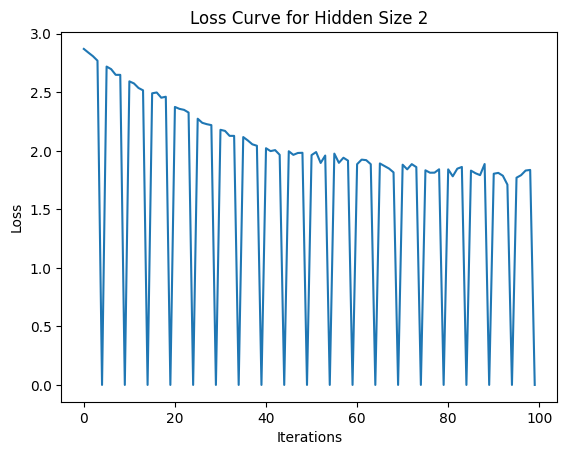

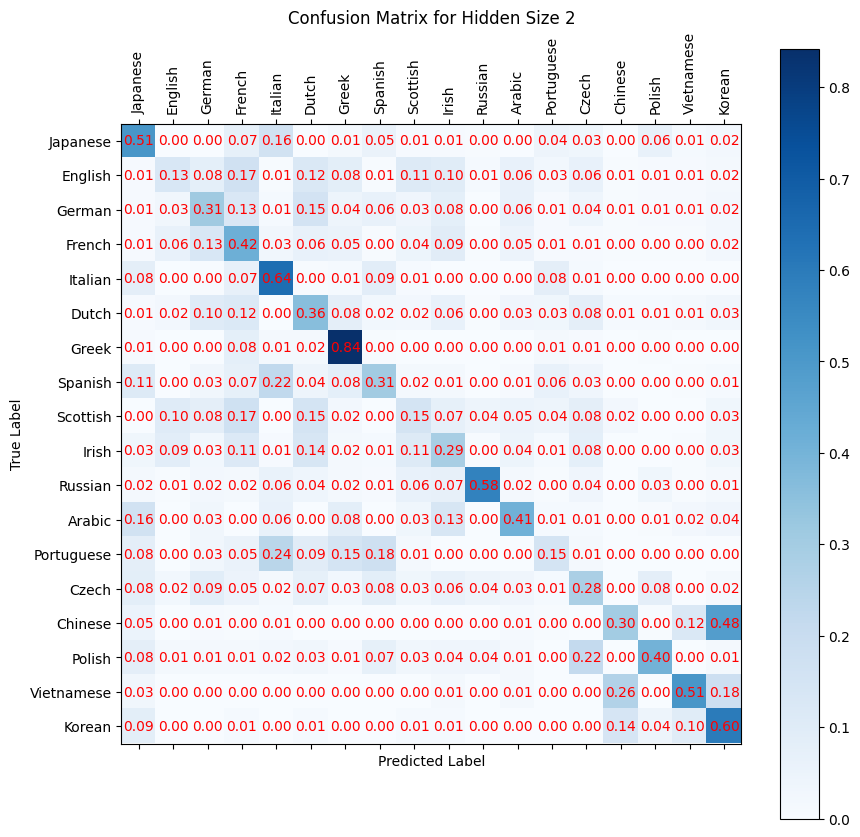

Training with hidden size 8
Iteration 5000: Loss = 0.5502204348087311
Iteration 10000: Loss = 0.5150170774698257
Iteration 15000: Loss = 0.49490602271556855
Iteration 20000: Loss = 0.435768636238575
Iteration 25000: Loss = 0.4058262204051018
Iteration 30000: Loss = 0.38634820716828105
Iteration 35000: Loss = 0.37096492893099786
Iteration 40000: Loss = 0.3647671661965549
Iteration 45000: Loss = 0.35698879220336677
Iteration 50000: Loss = 0.3473354039877653
Iteration 55000: Loss = 0.3485258500315249
Iteration 60000: Loss = 0.3356378535889089
Iteration 65000: Loss = 0.32010366435050963
Iteration 70000: Loss = 0.3380849123507738
Iteration 75000: Loss = 0.32326216723360124
Iteration 80000: Loss = 0.31672748823482544
Iteration 85000: Loss = 0.3190969314910471
Iteration 90000: Loss = 0.3231656966920942
Iteration 95000: Loss = 0.3250506681621075
Iteration 100000: Loss = 0.30724879691675305
Accuracy for hidden size 8: 45.42%


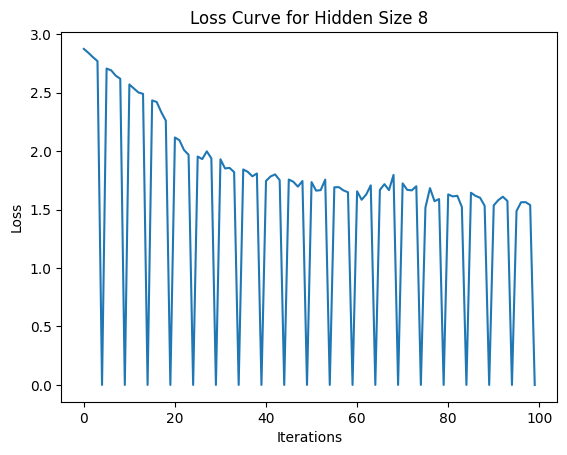

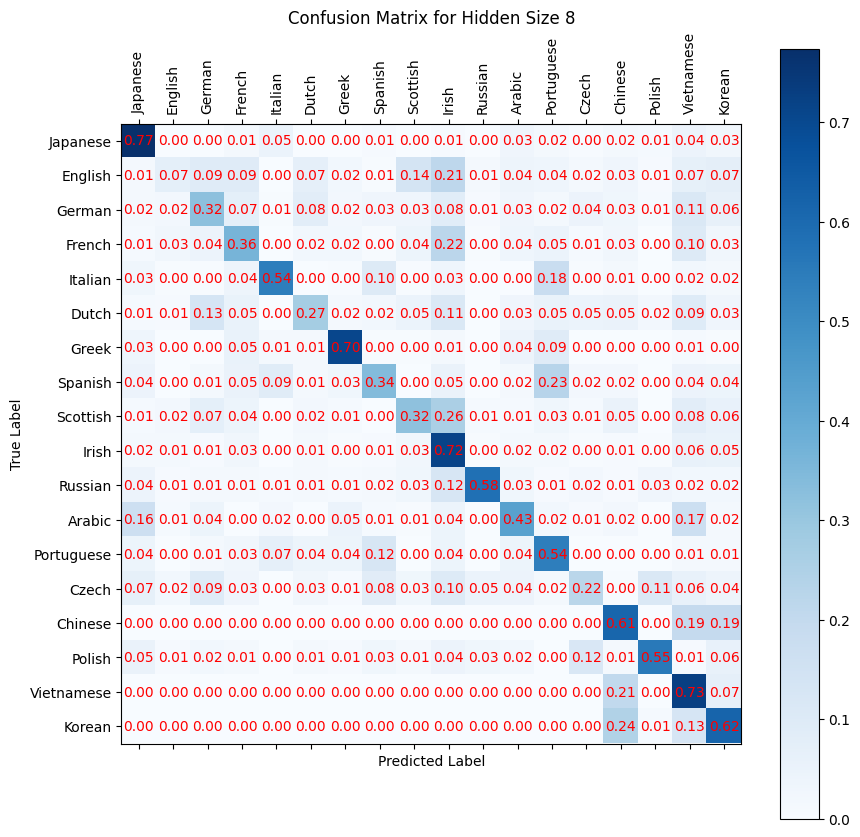

Training with hidden size 32
Iteration 5000: Loss = 0.5450859466552734
Iteration 10000: Loss = 0.48767380252331494
Iteration 15000: Loss = 0.432129907900095
Iteration 20000: Loss = 0.397118837967515
Iteration 25000: Loss = 0.3750962253782898
Iteration 30000: Loss = 0.3685912503030151
Iteration 35000: Loss = 0.348175617171824
Iteration 40000: Loss = 0.33223799217492345
Iteration 45000: Loss = 0.3257152530865278
Iteration 50000: Loss = 0.3093667776081711
Iteration 55000: Loss = 0.30377818574053234
Iteration 60000: Loss = 0.2999921407083981
Iteration 65000: Loss = 0.30194431404862554
Iteration 70000: Loss = 0.2831425043147057
Iteration 75000: Loss = 0.289160144212842
Iteration 80000: Loss = 0.28857895937948486
Iteration 85000: Loss = 0.281566817436181
Iteration 90000: Loss = 0.2672808961534407
Iteration 95000: Loss = 0.2765110225742306
Iteration 100000: Loss = 0.2768893531648442
Accuracy for hidden size 32: 57.24%


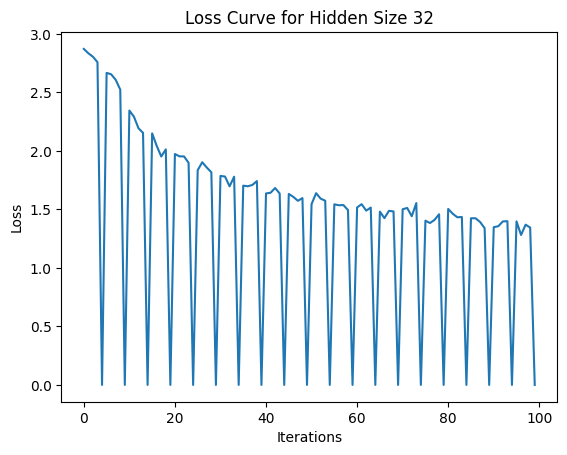

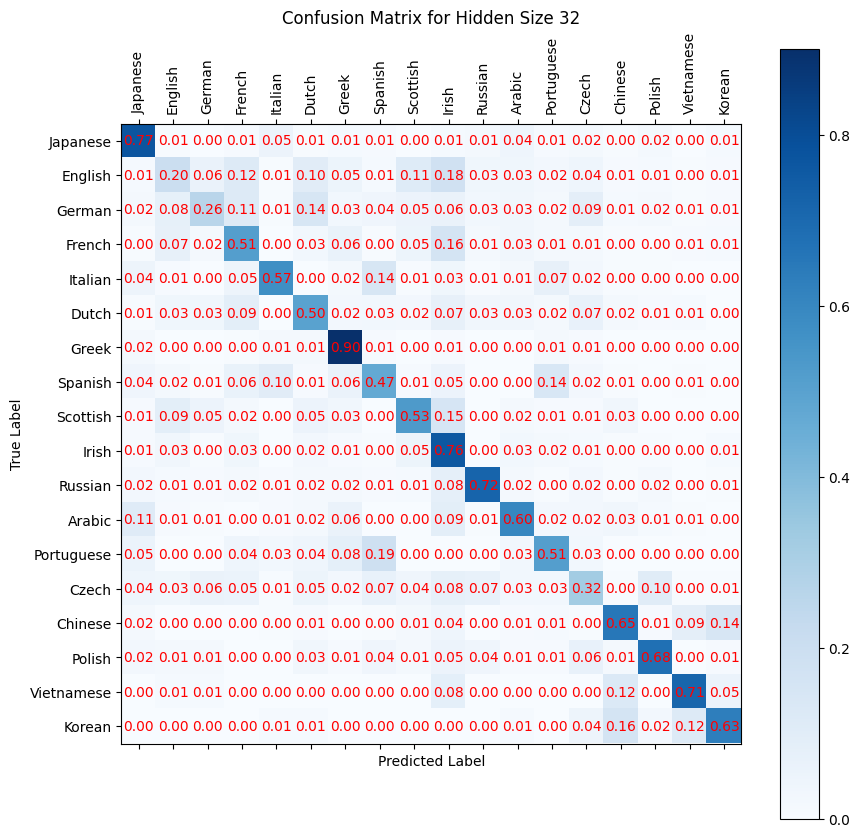

In [ ]:
import glob
import os
import unicodedata
import string
import torch
import torch.nn as nn
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Paths
data_dir = "/content/names/*.txt"

# Constants and Utilities
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

def findFiles(path): return glob.glob(path)

# Load data
names = {}
languages = []

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles(data_dir):
    category = os.path.splitext(os.path.basename(filename))[0]
    languages.append(category)
    lines = readLines(filename)
    names[category] = lines

n_categories = len(languages)

# Tensor Utilities
def letterToIndex(letter):
    return all_letters.find(letter)

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def nameToTensor(name):
    tensor = torch.zeros(len(name), 1, n_letters)
    for li, letter in enumerate(name):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

# Define RNN
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

# Training utilities
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i.item()
    return languages[category_i], category_i

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(languages)
    name = randomChoice(names[category])
    category_tensor = torch.tensor([languages.index(category)], dtype=torch.long)
    name_tensor = nameToTensor(name)
    return category, name, category_tensor, name_tensor

# Training function
criterion = nn.NLLLoss()
learning_rate = 0.005

def train(category_tensor, name_tensor, model, optimizer):
    hidden = model.initHidden()
    model.zero_grad()
    for i in range(name_tensor.size()[0]):
        output, hidden = model(name_tensor[i], hidden)
    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()
    return output, loss.item()

# Evaluate on full dataset
def evaluate(name_tensor, model):
    hidden = model.initHidden()
    for i in range(name_tensor.size()[0]):
        output, hidden = model(name_tensor[i], hidden)
    return output

def compute_accuracy(model):
    correct = 0
    total = 0
    for category in languages:
        for name in names[category]:
            category_tensor = torch.tensor([languages.index(category)], dtype=torch.long)
            name_tensor = nameToTensor(name)
            output = evaluate(name_tensor, model)
            guess, _ = categoryFromOutput(output)
            if guess == category:
                correct += 1
            total += 1
    return correct / total

# Training parameters
n_iters = 100000
print_every = 5000
plot_every = 1000

# Run for different hidden sizes
hidden_sizes = [2, 8, 32]
results = {}

for n_hidden in hidden_sizes:
    print(f"Training with hidden size {n_hidden}")
    rnn = RNN(n_letters, n_hidden, n_categories)
    optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)
    all_losses = []
    current_loss = 0

    for iter in range(1, n_iters + 1):
        category, name, category_tensor, name_tensor = randomTrainingExample()
        output, loss = train(category_tensor, name_tensor, rnn, optimizer)
        current_loss += loss

        if iter % print_every == 0:
            print(f"Iteration {iter}: Loss = {current_loss / print_every}")
            current_loss = 0

        if iter % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0

    # Compute accuracy
    accuracy = compute_accuracy(rnn)
    print(f"Accuracy for hidden size {n_hidden}: {accuracy * 100:.2f}%")

    # Confusion matrix
    confusion = torch.zeros(n_categories, n_categories)
    for category in languages:
        for name in names[category]:
            category_tensor = torch.tensor([languages.index(category)], dtype=torch.long)
            name_tensor = nameToTensor(name)
            output = evaluate(name_tensor, rnn)
            guess, guess_i = categoryFromOutput(output)
            category_i = languages.index(category)
            confusion[category_i][guess_i] += 1
    confusion = confusion / confusion.sum(1, keepdim=True)

    # Store results
    results[n_hidden] = {
        'accuracy': accuracy,
        'losses': all_losses,
        'confusion': confusion,
    }

    # Plot loss
    plt.figure()
    plt.plot(all_losses)
    plt.title(f"Loss Curve for Hidden Size {n_hidden}")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    # Plot confusion matrix with labels and heatmap
    fig, ax = plt.subplots(figsize=(10, 10))
    cax = ax.matshow(confusion.numpy(), cmap="Blues")
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticks(range(len(languages)))
    ax.set_yticks(range(len(languages)))
    ax.set_xticklabels(languages, rotation=90)
    ax.set_yticklabels(languages)

    # Add text annotations for each cell
    for i in range(len(languages)):
        for j in range(len(languages)):
            ax.text(j, i, f"{confusion[i, j]:.2f}", ha="center", va="center", color="red")

    plt.title(f"Confusion Matrix for Hidden Size {n_hidden}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# PART 1.2

Training with hidden size 2
Epoch 1
Epoch 1 Loss: 1.5378
Epoch 2
Epoch 2 Loss: 1.2725
Epoch 3
Epoch 3 Loss: 1.1658
Epoch 4
Epoch 4 Loss: 1.1167
Epoch 5
Epoch 5 Loss: 1.0896
Accuracy for hidden size 2: 65.61%


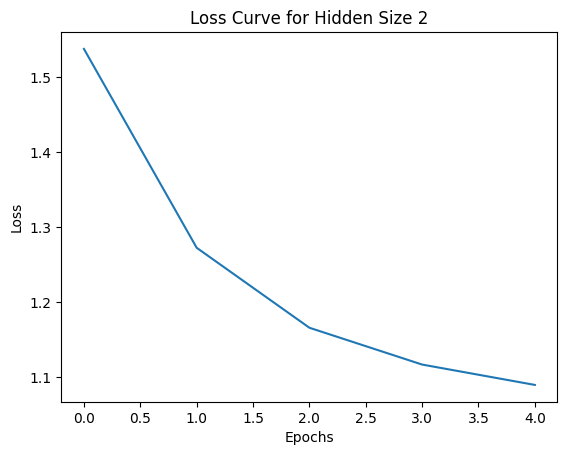

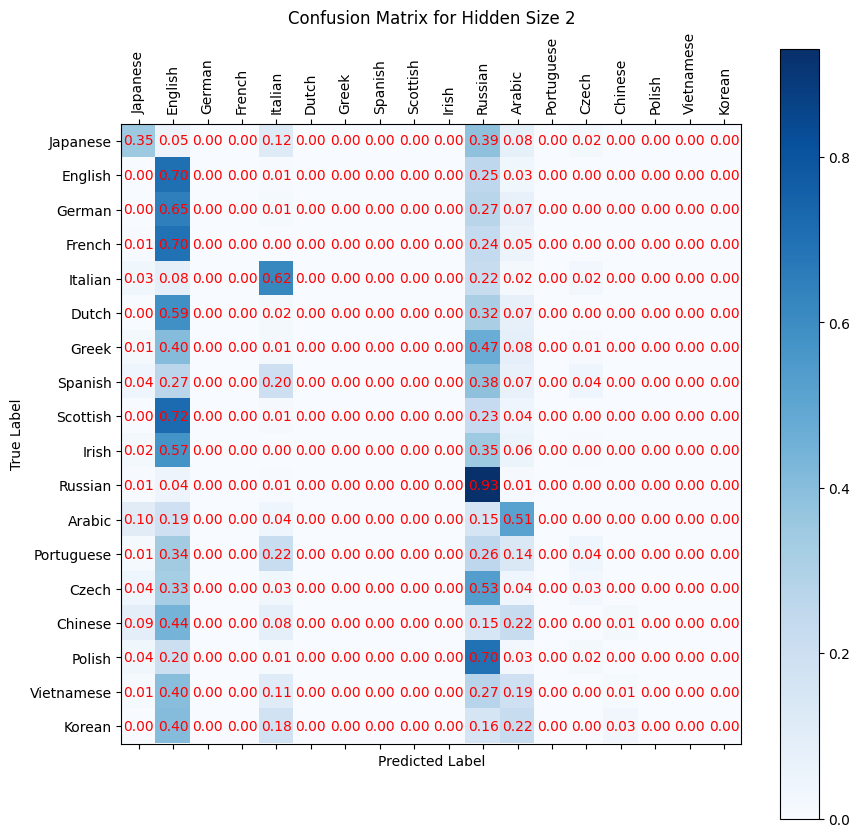

Training with hidden size 8
Epoch 1
Epoch 1 Loss: 1.4997
Epoch 2
Epoch 2 Loss: 1.1669
Epoch 3
Epoch 3 Loss: 1.0663
Epoch 4
Epoch 4 Loss: 1.0209
Epoch 5
Epoch 5 Loss: 0.9881
Accuracy for hidden size 8: 71.81%


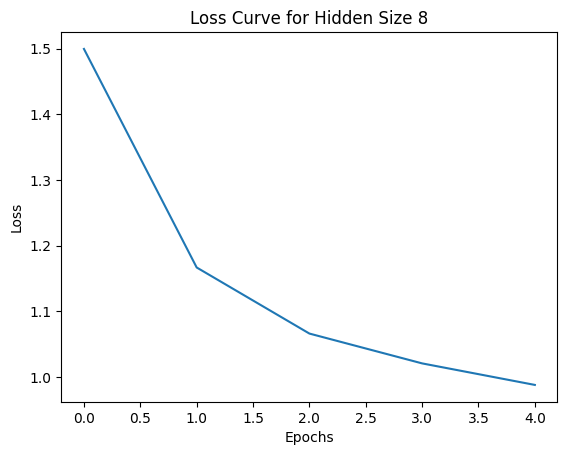

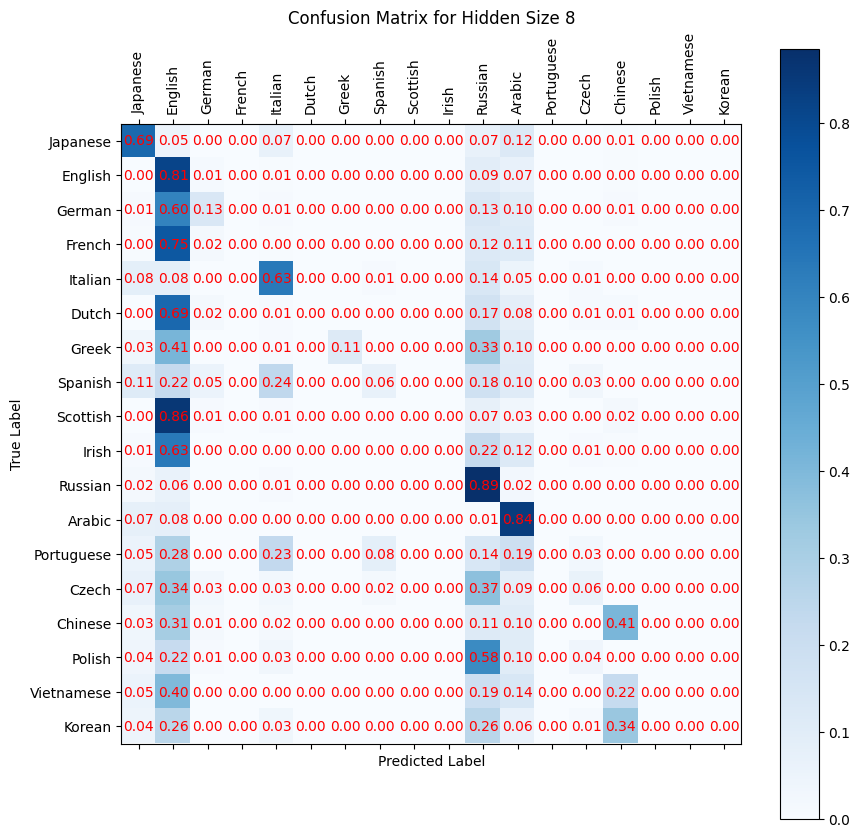

Training with hidden size 32
Epoch 1
Epoch 1 Loss: 1.4253
Epoch 2
Epoch 2 Loss: 1.1133
Epoch 3
Epoch 3 Loss: 1.0221
Epoch 4
Epoch 4 Loss: 0.9590
Epoch 5
Epoch 5 Loss: 0.9207
Accuracy for hidden size 32: 74.05%


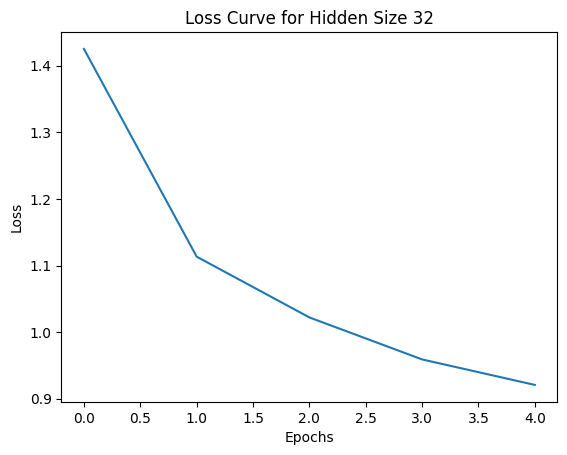

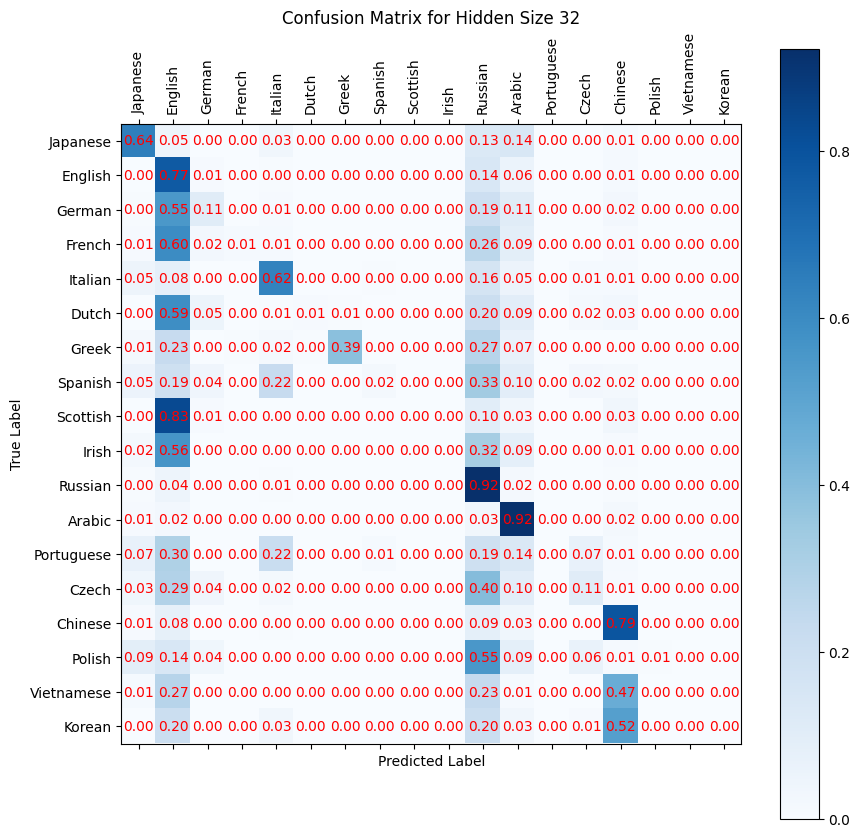

In [ ]:
import glob
import os
import unicodedata
import string
import torch
import torch.nn as nn
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

# Paths
data_dir = "/content/names/*.txt"

# Constants and Utilities
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

def findFiles(path): return glob.glob(path)

# Load data
names = {}
languages = []

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles(data_dir):
    category = os.path.splitext(os.path.basename(filename))[0]
    languages.append(category)
    lines = readLines(filename)
    names[category] = lines

n_categories = len(languages)

# Tensor Utilities
def letterToIndex(letter):
    return all_letters.find(letter)

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def nameToTensor(name):
    tensor = torch.zeros(len(name), 1, n_letters)
    for li, letter in enumerate(name):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

# Define RNN
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

# Training utilities
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i.item()
    return languages[category_i], category_i

def getAllSamples():
    samples = []
    for category in languages:
        for name in names[category]:
            category_tensor = torch.tensor([languages.index(category)], dtype=torch.long)
            name_tensor = nameToTensor(name)
            samples.append((category, name, category_tensor, name_tensor))
    return samples

# Training function
criterion = nn.NLLLoss()
learning_rate = 0.005

def train(category_tensor, name_tensor, model, optimizer):
    hidden = model.initHidden()
    model.zero_grad()
    for i in range(name_tensor.size()[0]):
        output, hidden = model(name_tensor[i], hidden)
    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()
    return output, loss.item()

# Evaluate on full dataset
def evaluate(name_tensor, model):
    hidden = model.initHidden()
    for i in range(name_tensor.size()[0]):
        output, hidden = model(name_tensor[i], hidden)
    return output

def compute_accuracy(model):
    correct = 0
    total = 0
    for category in languages:
        for name in names[category]:
            category_tensor = torch.tensor([languages.index(category)], dtype=torch.long)
            name_tensor = nameToTensor(name)
            output = evaluate(name_tensor, model)
            guess, _ = categoryFromOutput(output)
            if guess == category:
                correct += 1
            total += 1
    return correct / total

# Training parameters
epochs = 5
hidden_sizes = [2, 8, 32]
results = {}

# Run for different hidden sizes
for n_hidden in hidden_sizes:
    print(f"Training with hidden size {n_hidden}")
    rnn = RNN(n_letters, n_hidden, n_categories)
    optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)
    all_losses = []
    samples = getAllSamples()

    for epoch in range(1, epochs + 1):
        print(f"Epoch {epoch}")
        random.shuffle(samples)  # Randomize samples at the start of each epoch
        current_loss = 0
        for category, name, category_tensor, name_tensor in samples:
            output, loss = train(category_tensor, name_tensor, rnn, optimizer)
            current_loss += loss
        all_losses.append(current_loss / len(samples))
        print(f"Epoch {epoch} Loss: {current_loss / len(samples):.4f}")

    # Compute accuracy
    accuracy = compute_accuracy(rnn)
    print(f"Accuracy for hidden size {n_hidden}: {accuracy * 100:.2f}%")

    # Confusion matrix
    confusion = torch.zeros(n_categories, n_categories)
    for category in languages:
        for name in names[category]:
            category_tensor = torch.tensor([languages.index(category)], dtype=torch.long)
            name_tensor = nameToTensor(name)
            output = evaluate(name_tensor, rnn)
            guess, guess_i = categoryFromOutput(output)
            category_i = languages.index(category)
            confusion[category_i][guess_i] += 1
    confusion = confusion / confusion.sum(1, keepdim=True)

    # Store results
    results[n_hidden] = {
        'accuracy': accuracy,
        'losses': all_losses,
        'confusion': confusion,
    }

    # Plot loss
    plt.figure()
    plt.plot(all_losses)
    plt.title(f"Loss Curve for Hidden Size {n_hidden}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(10, 10))
    cax = ax.matshow(confusion.numpy(), cmap="Blues")
    fig.colorbar(cax)
    ax.set_xticks(range(len(languages)))
    ax.set_yticks(range(len(languages)))
    ax.set_xticklabels(languages, rotation=90)
    ax.set_yticklabels(languages)

    for i in range(len(languages)):
        for j in range(len(languages)):
            ax.text(j, i, f"{confusion[i, j]:.2f}", ha="center", va="center", color="red")

    plt.title(f"Confusion Matrix for Hidden Size {n_hidden}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

## PART 2.1

In [ ]:
import glob
import os
import unicodedata
import string
import torch
import torch.nn as nn
import random
import numpy as np

# Paths
data_dir = "/content/names/*.txt"

# Constants
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Load Data
names = {}
languages = []

def findFiles(path): return glob.glob(path)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles(data_dir):
    category = os.path.splitext(os.path.basename(filename))[0]
    languages.append(category)
    lines = readLines(filename)
    names[category] = lines

n_categories = len(languages)

# Utility Functions
def letterToIndex(letter):
    return all_letters.find(letter)

def nameToTensor(name):
    tensor = torch.zeros(len(name), n_letters)
    for li, letter in enumerate(name):
        tensor[li][letterToIndex(letter)] = 1
    return tensor

def pad_sequence(sequences, max_len):
    """Pads all sequences to the max length."""
    padded = torch.zeros(len(sequences), max_len, n_letters)
    for i, seq in enumerate(sequences):
        padded[i, :seq.size(0), :] = seq
    return padded

# Model Definition
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True
        )
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        r_out, h = self.rnn(x, None)
        out = self.out(r_out[:, -1, :])  # Use the output at the last time step
        return out

# Prepare Data for Batch Training
all_names = []
for category in names:
    for name in names[category]:
        all_names.append((name, languages.index(category)))

# Determine Maximum Length of Names
max_len = max(len(name) for name, _ in all_names)

# Prepare Batches
def create_batch(all_names):
    random.shuffle(all_names)
    input_tensors = [nameToTensor(name) for name, _ in all_names]
    output_tensors = torch.tensor([category for _, category in all_names], dtype=torch.long)
    return pad_sequence(input_tensors, max_len), output_tensors

# Training Parameters
n_hidden = 128
learning_rate = 0.005
epochs = 5

# Initialize Model, Loss, and Optimizer
rnn = RNN(n_letters, n_hidden, n_categories)
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
loss_func = nn.CrossEntropyLoss()

# Training Loop
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    inputs, targets = create_batch(all_names)

    # Forward Pass
    outputs = rnn(inputs)
    loss = loss_func(outputs, targets)

    # Backward Pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Accuracy Calculation
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == targets).sum().item() / len(targets)

    print(f"Loss: {loss.item():.4f}, Accuracy: {accuracy * 100:.2f}%")

# Evaluate Final Accuracy on Full Dataset
inputs, targets = create_batch(all_names)
outputs = rnn(inputs)
_, predicted = torch.max(outputs, 1)
final_accuracy = (predicted == targets).sum().item() / len(targets)

print(f"Final Accuracy after 5 Epochs: {final_accuracy * 100:.2f}%")

Epoch 1/5
Loss: 2.9087, Accuracy: 1.34%
Epoch 2/5
Loss: 2.6703, Accuracy: 46.87%
Epoch 3/5
Loss: 2.1673, Accuracy: 46.87%
Epoch 4/5
Loss: 2.0512, Accuracy: 46.87%
Epoch 5/5
Loss: 1.9426, Accuracy: 46.87%
Final Accuracy after 5 Epochs: 46.87%


# PART 2.2

In [ ]:
import glob
import os
import unicodedata
import string
import torch
import torch.nn as nn
import random
import numpy as np

# Paths
data_dir = "/content/names/*.txt"

# Constants
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Load Data
names = {}
languages = []

def findFiles(path): return glob.glob(path)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles(data_dir):
    category = os.path.splitext(os.path.basename(filename))[0]
    languages.append(category)
    lines = readLines(filename)
    names[category] = lines

n_categories = len(languages)

# Utility Functions
def letterToIndex(letter):
    return all_letters.find(letter)

def nameToTensor(name):
    tensor = torch.zeros(len(name), n_letters)
    for li, letter in enumerate(name):
        tensor[li][letterToIndex(letter)] = 1
    return tensor

def pad_batch(sequences):
    """Dynamically pads sequences to the length of the longest sequence in the batch."""
    max_len = max(seq.size(0) for seq in sequences)
    padded = torch.zeros(len(sequences), max_len, n_letters)
    for i, seq in enumerate(sequences):
        padded[i, :seq.size(0), :] = seq
    return padded

# Model Definition
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True
        )
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        r_out, h = self.rnn(x, None)
        out = self.out(r_out[:, -1, :])  # Use the output at the last time step
        return out

# Prepare Data for Mini-Batch Training
all_names = []
for category in names:
    for name in names[category]:
        all_names.append((name, languages.index(category)))

# Mini-Batch Generator
def create_mini_batches(data, batch_size):
    random.shuffle(data)
    for i in range(0, len(data), batch_size):
        batch = data[i:i+batch_size]
        input_tensors = [nameToTensor(name) for name, _ in batch]
        output_tensors = torch.tensor([category for _, category in batch], dtype=torch.long)
        yield pad_batch(input_tensors), output_tensors

# Training Parameters
n_hidden = 128
learning_rate = 0.005
epochs = 5

# Train Model for Different Batch Sizes
batch_sizes = [1000, 2000, 3000]
results = {}

for batch_size in batch_sizes:
    print(f"Training with batch size {batch_size}")
    rnn = RNN(n_letters, n_hidden, n_categories)
    optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
    loss_func = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        total_loss = 0
        for inputs, targets in create_mini_batches(all_names, batch_size):
            # Forward Pass
            outputs = rnn(inputs)
            loss = loss_func(outputs, targets)

            # Backward Pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / (len(all_names) // batch_size)
        print(f"Epoch {epoch + 1}, Average Loss: {avg_loss:.4f}")

    # Evaluate Accuracy
    correct = 0
    total = 0
    for inputs, targets in create_mini_batches(all_names, batch_size):
        outputs = rnn(inputs)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == targets).sum().item()
        total += targets.size(0)

    accuracy = correct / total
    print(f"Final Accuracy with Batch Size {batch_size}: {accuracy * 100:.2f}%")
    results[batch_size] = accuracy

# Print Final Results
print("Results:")
for batch_size, accuracy in results.items():
    print(f"Batch Size {batch_size}: Accuracy = {accuracy * 100:.2f}%")

Training with batch size 1000
Epoch 1/5
Epoch 1, Average Loss: 2.0920
Epoch 2/5
Epoch 2, Average Loss: 1.9497
Epoch 3/5
Epoch 3, Average Loss: 1.9586
Epoch 4/5
Epoch 4, Average Loss: 1.9472
Epoch 5/5
Epoch 5, Average Loss: 1.9398
Final Accuracy with Batch Size 1000: 46.87%
Training with batch size 2000
Epoch 1/5
Epoch 1, Average Loss: 2.3330
Epoch 2/5
Epoch 2, Average Loss: 2.0542
Epoch 3/5
Epoch 3, Average Loss: 2.0606
Epoch 4/5
Epoch 4, Average Loss: 2.0231
Epoch 5/5
Epoch 5, Average Loss: 2.0264
Final Accuracy with Batch Size 2000: 46.87%
Training with batch size 3000
Epoch 1/5
Epoch 1, Average Loss: 2.5611
Epoch 2/5
Epoch 2, Average Loss: 2.1892
Epoch 3/5
Epoch 3, Average Loss: 2.1674
Epoch 4/5
Epoch 4, Average Loss: 2.1583
Epoch 5/5
Epoch 5, Average Loss: 2.1580
Final Accuracy with Batch Size 3000: 46.87%
Results:
Batch Size 1000: Accuracy = 46.87%
Batch Size 2000: Accuracy = 46.87%
Batch Size 3000: Accuracy = 46.87%
